# Imports and Data Download

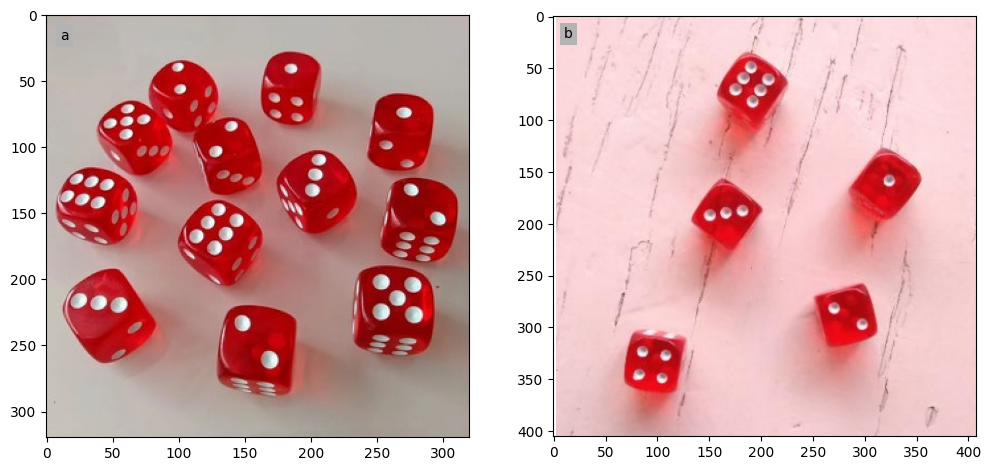

In [70]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


names_list = ["dados2.jpg", "dados3.png"]

img_list = []
for i, name in enumerate(names_list):
    img_list.append(cv2.imread(name))
    img_list[i] = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB)

def show_imgs(img_list, legend = []):
    _, axs = plt.subplots(1,2, figsize=(12, 12))
    for i, img in enumerate(img_list):
        axs[i].imshow(img,cmap='gray')
        if legend != []:
            axs[i].text(10.0, 10.0, 
                        legend[i],
                        fontsize='medium',
                        verticalalignment='top',
                        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    plt.show()
        
show_imgs(img_list)

# Image preprocessing

## Color -> Gray Scale -> Median Filter [1]

Images changed to gray scale, as there is no need for color input

Then a median filter is applied -> Each pixel gets middle ground value from adjacent pixels
- Removes salt and pepper noise
- Removes extreme values
- Surfaces get homogeneous, with fewer color steps
- Does not blur edges with color gradients

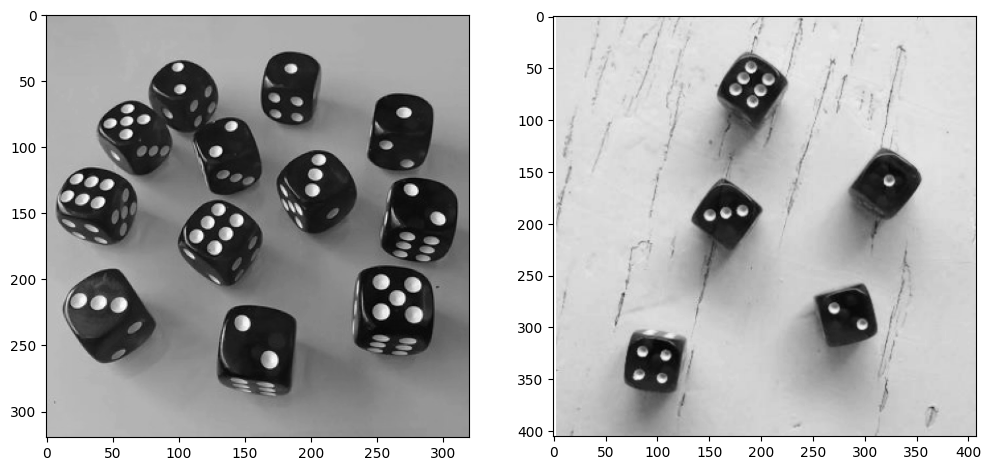

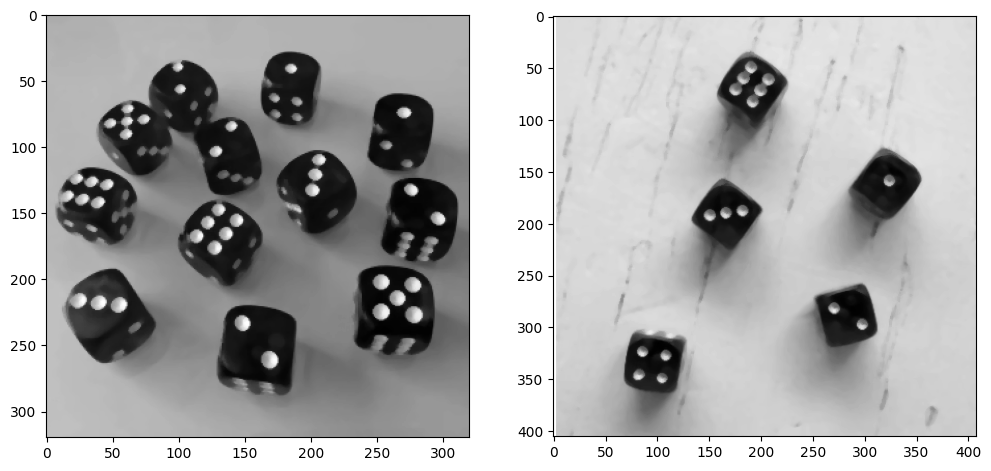

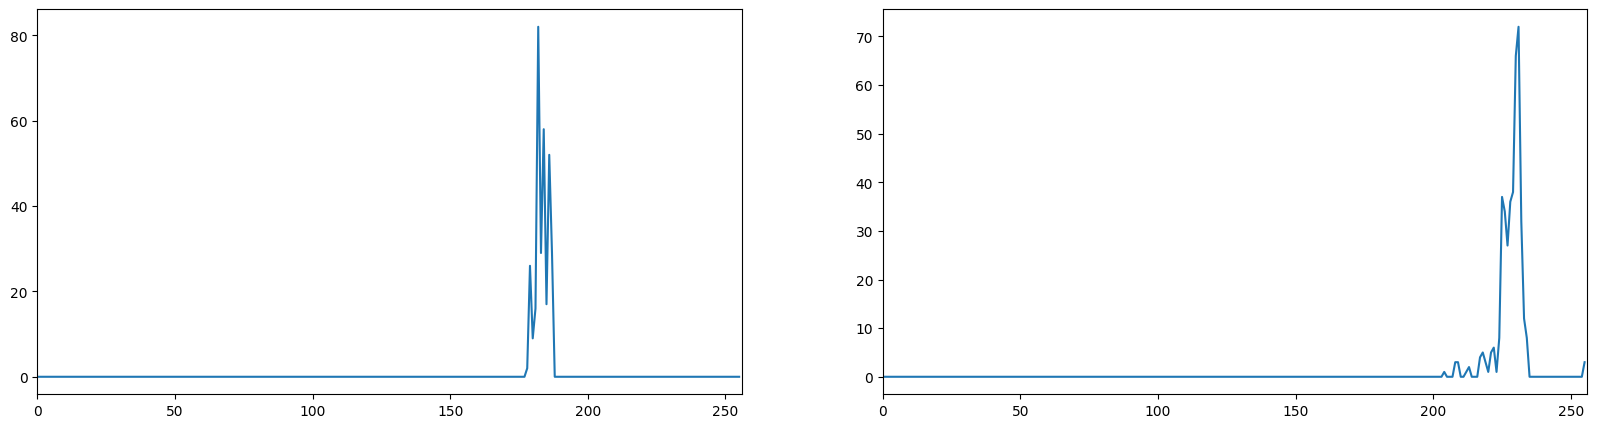

In [53]:
# Removing colors
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in img_list]
show_imgs(gray_imgs)
# Applying median blur for better feature extraction 
# Enhancing strong whites on top, while darkening and blurring lateral dots
median_imgs = [cv2.medianBlur(img, 5) for img in gray_imgs]

show_imgs(median_imgs)

def histograms(img_list):
    _, axs = plt.subplots(1,2, figsize=(20, 5))
    for i, img in enumerate(img_list):
        hist = cv2.calcHist(img, [0], None, [256], [0, 256])
        fig = axs[i]

        fig.plot(hist)
        fig.set_xlim([0, 256])
        
histograms(median_imgs)

## Thresholding [2]

Image turned binary by choosing a threshold value

`
if val < threshold:
    return 0
else:
    return 1
`

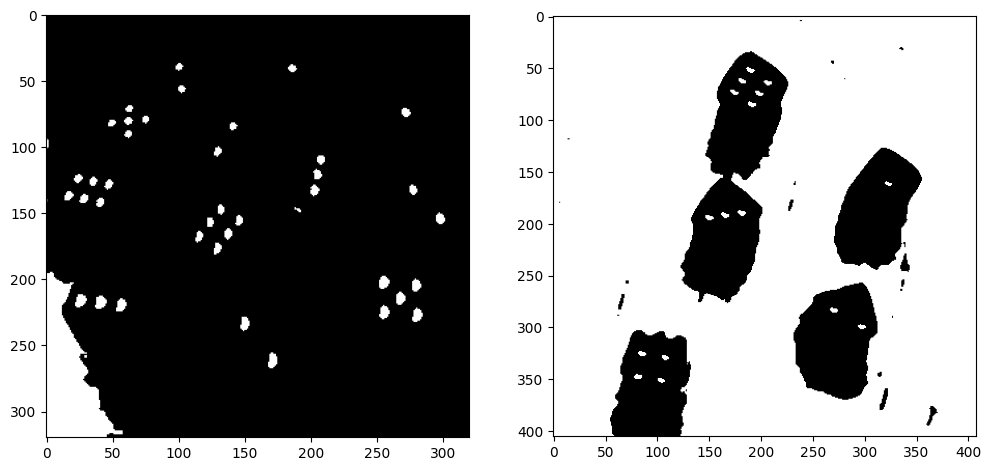

In [54]:
# Thresholding to enhance desired features
thresh_imgs = [cv2.threshold(img, 190, 255, cv2.THRESH_BINARY)[1] for img in median_imgs]
show_imgs(thresh_imgs)

## Apply morphology [3]

### Open: Erode -> Dilate

Removing **background noise**

Removes small **objects**, but preserves larger shapes

First erodes whites -> White pixels with neighboring blacks become black
- Removes sharp edges, floating pixels and thin lines
- Only substantive pixels remain
- Thins objects

Then dilates whites -> Black pixels with neighboring whites become white
- Fills up holes and shapes
- Thickens objects

Observe the reminiscent lateral dot under the dice with a 3 at (200, 100) disappeared

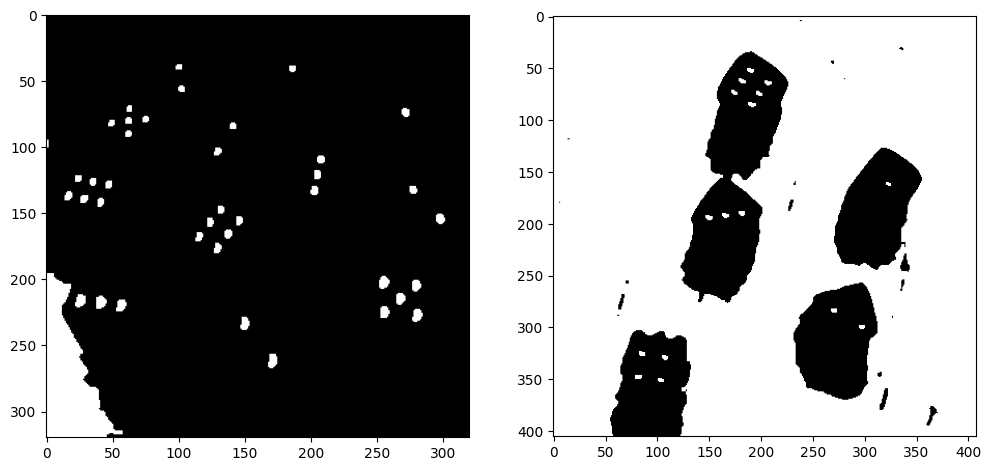

In [55]:
# Applying morphology to clean up dots
kernel = np.ones((3,3),np.uint8)
# Removing background noise
open_imgs = [cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) for img in thresh_imgs]
show_imgs(open_imgs)

### Close: Dilate -> Erode

Removing **object noise**

Fills small **holes**, but preserves larger shapes

First dilates whites -> Black pixels with neighboring whites become white
- Fills up holes and shapes
- Thins holes

Then erodes whites -> White pixels with neighboring blacks become black
- Removes sharp edges, floating pixels and thin lines
- Only substantive pixels remain
- Thickens holes

Observe the reminiscent table markings at (250~300, 50) disappeared

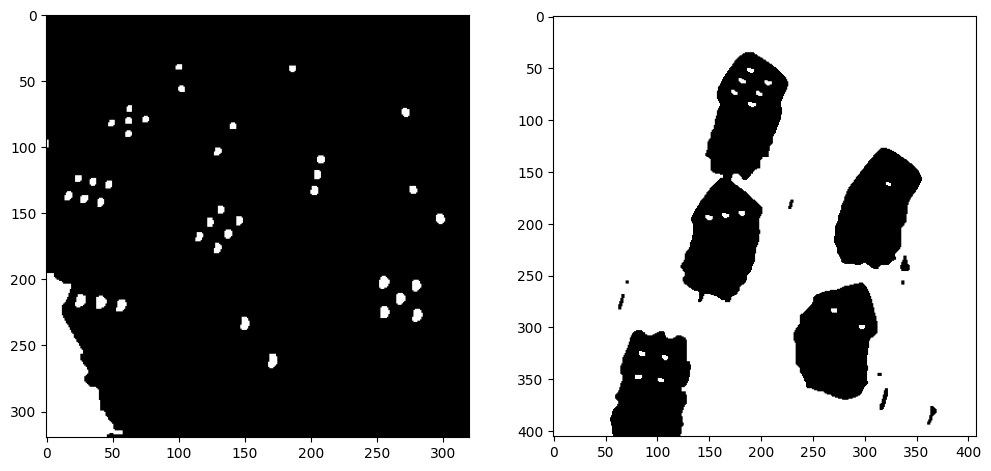

In [56]:
# Removing object noise
closed_imgs = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in open_imgs]
show_imgs(closed_imgs)

### Dilate

**Highlighting objects** and flattening some of their concavities

Dilates whites -> Black pixels with neighboring whites become white
- Fills up holes and shapes
- Thickens objects
- Thins holes

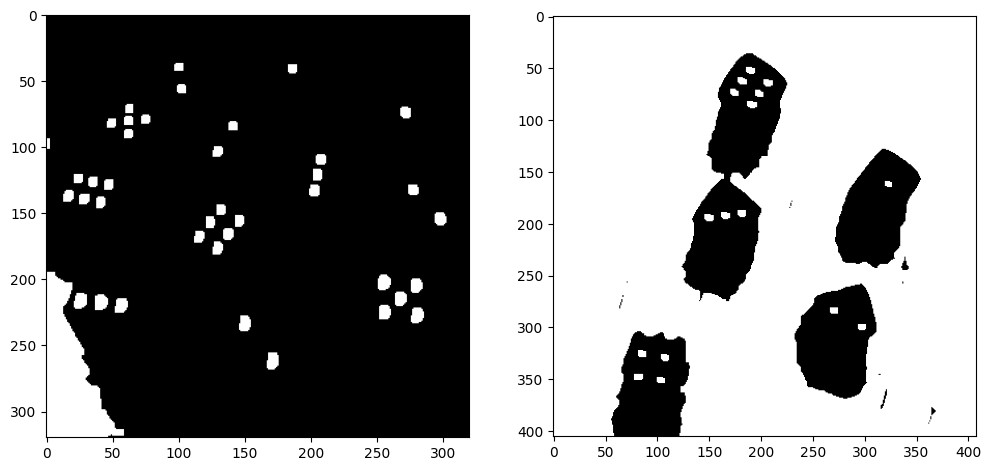

In [57]:
# Dilating dots for better blob recognition 
dilated_imgs = [cv2.dilate(img, kernel, iterations = 1) for img in closed_imgs]
show_imgs(dilated_imgs)

## Invert pixels

We have white objects on black background, but object detection function looks for black objects on white background 

Objects look smaller due to human eye bias to white vs black gradients [4]
- White registers better as lighting
- Black registers better as object features

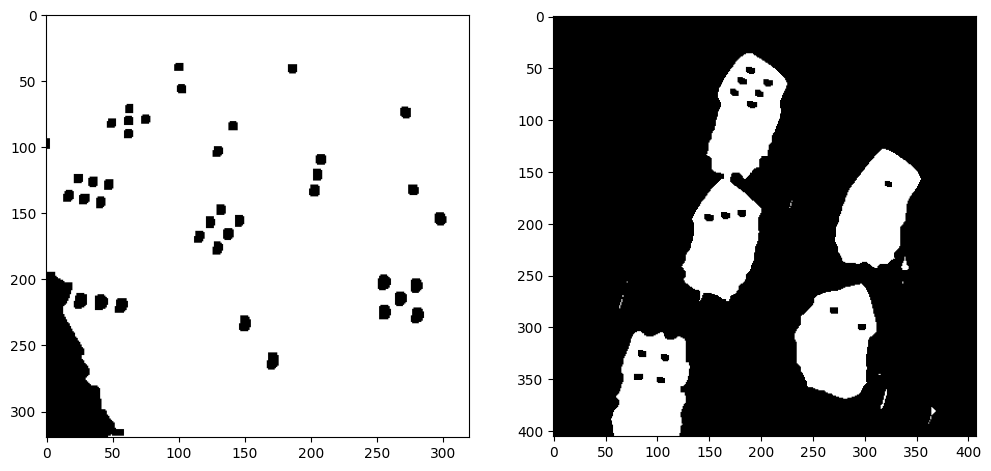

In [58]:
# Inverting image for blob to operate on black dots
inverted_imgs = [cv2.bitwise_not(img) for img in dilated_imgs]
show_imgs(inverted_imgs)

# Algorithm

## Blob Detection [5]

Detecting dice dots with **Blob Detection**

What is a blob? A grouping of connected pixels

Algorithm works by: 
- Calculates connected white pixels centroids
- Considers as blobs depending on shape parameters
- Merge blobs depending on distance parameters


Searching blobs by convexity:
- Most of our target objects are convex "semicircles", With a bit over 180 degrees
- Trial and error showed best results 

Searching blobs by Area:
- Most of our target objects fit similar areas (pixel counts)
- Trial and error showed best results 

In [59]:
# Detecting dots
params = cv2.SimpleBlobDetector_Params()

params.minDistBetweenBlobs = 1

# params.minThreshold = 90
# params.maxThreshold = 255

# params.filterByCircularity = True
# params.minCircularity = 0.3

params.filterByConvexity = True
params.minConvexity = 0.1

# params.filterByInertia = True
# params.minInertiaRatio = 0.5

params.filterByArea = True
params.minArea = 10
# params.maxArea = 100

detector = cv2.SimpleBlobDetector_create(params)

dots = [detector.detect(img) for img in inverted_imgs]

## Image overlapping

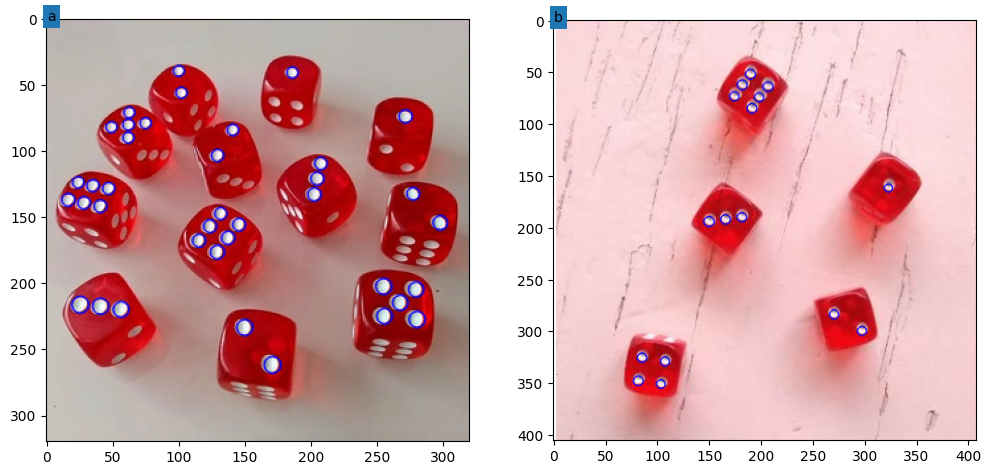

In [60]:
marked_imgs = [cv2.drawKeypoints(img, img_dot, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) for img, img_dot in zip(img_list, dots)]
show_imgs(marked_imgs)

## Clustering values

Finally, blob results are clustered.

DBSCAN [6] used due to its focus on density
- Finds core samples of high density and expands clusters from them
- Good for data which contains clusters of similar density

In [77]:
from sklearn.cluster import DBSCAN as dbs


def cluster_calc(imgs, dots):
    outputs = []
    for img, img_dots in zip(imgs, dots):
    # Clusterization
        coords = []
        for dot in img_dots:
            dot = dot.pt
            coords.append(dot)

        # Clustering results for dice count
        clusters = dbs(eps=35.5, min_samples=1).fit(coords)

        labels = np.unique(clusters.labels_)

        roll_sum = len(clusters.labels_)
        dice_number = len(labels)
        
        text = f"Dice count: {dice_number}\nRoll count: {roll_sum}"
    
        outputs.append(text)
    return outputs

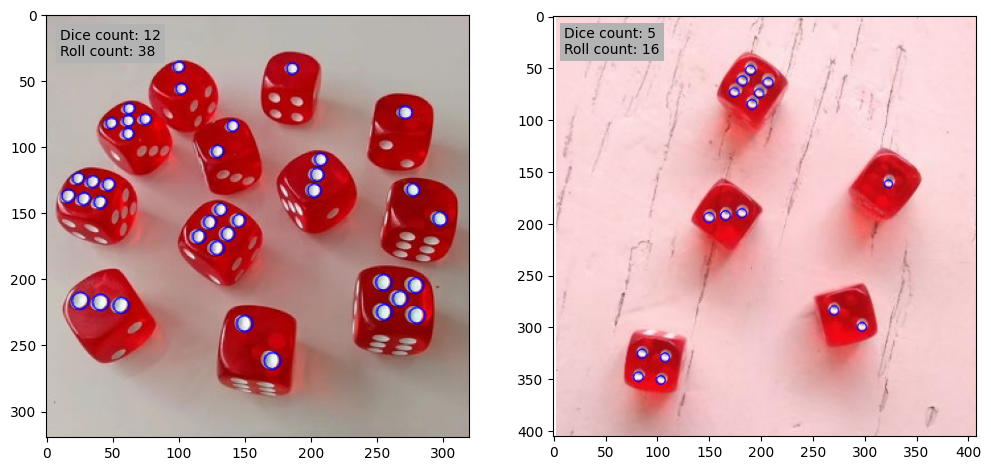

In [78]:
show_imgs(marked_imgs, cluster_calc(marked_imgs, dots))

Bibliography:

[1] Median Filter - https://en.wikipedia.org/wiki/Median_filter

[2] Thresholding - https://en.wikipedia.org/wiki/Thresholding_(image_processing)

[3] Morphology - https://www.mathworks.com/help/images/morphological-dilation-and-erosion.html

[4] Grayscale biological bias - https://blogs.getty.edu/iris/black-and-white-arent-opposites-after-all/

[5] Blob Detector - https://learnopencv.com/blob-detection-using-opencv-python-c/

[6] DBSCAN - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html